# CSC 522
# Project Title: Detecting objects in images using computer vision
# Project Group: P29
# Member(s): Pankaj Attri (pattri@ncsu.edu)

In [ ]:
# Import necessry tensorflow libraries and packages

import pandas as pd
import numpy as np
import time

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, AveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, Conv2DTranspose, Input, BatchNormalization, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import load_model


In [4]:
# Helper function to extract images and labels from pickle file
# Source https://www.cs.toronto.edu/~kriz/cifar.html

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
# Extract train and test data and metadata

train_data_dict = unpickle('/home/ubuntu/CSC522/Data/train')
test_data_dict = unpickle('/home/ubuntu/CSC522/Data/test')
metadata = unpickle('/home/ubuntu/CSC522/Data/meta')

In [6]:
# Data set analysis: Number of training and test images

print('Train and test dictionary contents:',train_data_dict.keys(),'\n')

print('Number of images in the train data set:', len(train_data_dict[b'filenames']))
print('Number of images in the test data set:', len(test_data_dict[b'filenames']))


Train and test dictionary contents: dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data']) 

Number of images in the train data set: 50000
Number of images in the test data set: 10000


In [7]:
# Data set analysis: Number of unqiue fine and coarse lables in the train and test datasets

print('Unique fine label classes in the training data set:', len(np.unique(train_data_dict[b'fine_labels'])))
print('Unique coarse labels classes in the training data set:', len(np.unique(train_data_dict[b'coarse_labels'])),'\n')

print('Unique fine label classes in the test data set:', len(np.unique(test_data_dict[b'fine_labels'])))
print('Unique coarse labels classes in the test data set:', len(np.unique(test_data_dict[b'coarse_labels'])))

Unique fine label classes in the training data set: 100
Unique coarse labels classes in the training data set: 20 

Unique fine label classes in the test data set: 100
Unique coarse labels classes in the test data set: 20


In [8]:
# Data set analysis: metadata file

metadata.keys()
for i in range(len(metadata[b'fine_label_names'])):
    print(str(metadata[b'fine_label_names'][i],'utf-8'), ' ')


apple  
aquarium_fish  
baby  
bear  
beaver  
bed  
bee  
beetle  
bicycle  
bottle  
bowl  
boy  
bridge  
bus  
butterfly  
camel  
can  
castle  
caterpillar  
cattle  
chair  
chimpanzee  
clock  
cloud  
cockroach  
couch  
crab  
crocodile  
cup  
dinosaur  
dolphin  
elephant  
flatfish  
forest  
fox  
girl  
hamster  
house  
kangaroo  
keyboard  
lamp  
lawn_mower  
leopard  
lion  
lizard  
lobster  
man  
maple_tree  
motorcycle  
mountain  
mouse  
mushroom  
oak_tree  
orange  
orchid  
otter  
palm_tree  
pear  
pickup_truck  
pine_tree  
plain  
plate  
poppy  
porcupine  
possum  
rabbit  
raccoon  
ray  
road  
rocket  
rose  
sea  
seal  
shark  
shrew  
skunk  
skyscraper  
snail  
snake  
spider  
squirrel  
streetcar  
sunflower  
sweet_pepper  
table  
tank  
telephone  
television  
tiger  
tractor  
train  
trout  
tulip  
turtle  
wardrobe  
whale  
willow_tree  
wolf  
woman  
worm  


In [9]:
# helper function to convert a single row in the dataset into a numpy array of sie 32x32x3
def convertToRBG(array):
    final_image_array = np.zeros(shape=(32,32,3))
    red_channel = np.reshape(array[0:1024],[32,32])
    green_channel = np.reshape(array[1024:2048],[32,32])
    blue_channel = np.reshape(array[2048:3072],[32,32])
    final_image_array = np.dstack((red_channel,green_channel,blue_channel))
    return final_image_array

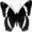

In [10]:
# print a test Grayscale image
p = np.reshape(train_data_dict[b'data'][2343][2048:3072],[32,32])
Image.fromarray(p)

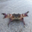

In [11]:
# Print a random test colored image
Image.fromarray(convertToRBG(train_data_dict[b'data'][5456]))


In [12]:
# label of the random image
str(metadata[b'fine_label_names'][train_data_dict[b'fine_labels'][5456]],'utf-8')

'crab'

In [13]:
# Read indexes of images in an array to be used to split data into train and validate datasets
all_class_indexes = []
for j in range(100):
    all_class_indexes.append([])
    
for i in range(len(train_data_dict[b'data'])):
    current_index = train_data_dict[b'fine_labels'][i]
    all_class_indexes[current_index].append(i)
        

In [14]:
# select first 100 images in class for validate and remaining for train data set, making the 
# split between train, test, and valdiate to 40,000, 10,000, 10,000
val_data_indexes = []
train_data_indexes = []
for i in range(len(all_class_indexes)):
    
    val_data_indexes.append(all_class_indexes[i][0:100])
    train_data_indexes.append(all_class_indexes[i][100:500])
    

In [18]:
# Shuffle images in the data set

shuffled_train_indexes_df = pd.DataFrame(columns=['image_index','y'])
shuffled_val_indexes_df = pd.DataFrame(columns=['image_index','y'])
for i in range (0,len(train_data_indexes)):
    for j in range(len(train_data_indexes[i])):
        shuffled_train_indexes_df = shuffled_train_indexes_df.append({'image_index' : train_data_indexes[i][j] , 'y' : i} , ignore_index=True)
for i in range (0,len(val_data_indexes)):
    for j in range(len(val_data_indexes[i])):
        shuffled_val_indexes_df = shuffled_val_indexes_df.append({'image_index' : val_data_indexes[i][j] , 'y' : i} , ignore_index=True)

In [20]:
# Create train and validate data sets

train_data = [[]]
validate_data = [[]]
arrays_list_train = []
arrays_list_val = []

for i in range (0,len(shuffled_train_indexes_df['image_index'])):
    arrays_list_train.append(convertToRBG(train_data_dict[b'data'][shuffled_train_indexes_df['image_index'][i]]))
for i in range (0,len(shuffled_val_indexes_df['image_index'])):
    arrays_list_val.append(convertToRBG(train_data_dict[b'data'][shuffled_val_indexes_df['image_index'][i]]))
train_data = np.stack(tuple(arrays_list_train))
val_data = np.stack(tuple(arrays_list_val))



In [21]:
# Store original data in ALL_data to be used for GridSearchCV for hyper parameter tuning (if using Keras GridSearchCV).

ALL_data = [[]]
arrays_list_ALL = []
for i in range (0,len(train_data_dict[b'data'])):
    arrays_list_ALL.append(convertToRBG(train_data_dict[b'data'][i]))
ALL_data = np.stack(tuple(arrays_list_ALL))

In [22]:
# Create test data set
test_data = [[]]
arrays_list_test = []
for i in range (0,len(test_data_dict[b'data'])):
    arrays_list_test.append(convertToRBG(test_data_dict[b'data'][i]))
test_data = np.stack(tuple(arrays_list_test))

In [23]:
# helper function to get fine and coarse label name for an image based on the numerical label

def labels(fine_label_id,coarse_label_id,dataset):
    return dataset[b'fine_label_names'][fine_label_id].decode('utf-8'),dataset[b'coarse_label_names'][coarse_label_id].decode('utf-8')

In [28]:
# Data pre-processing
# Standardize/ Normalize data

train_data = train_data.astype('float32')
test_data = test_data.astype('float32')
val_data = val_data.astype('float32')

'''
#Normalization
train_data /= 255
test_data /= 255
val_data /= 255
'''

# Standardization
train_data = train_data/127.5 - 1.
test_data = test_data/127.5 - 1.
val_data = val_data/127.5 - 1.

y_test = np.asarray(test_data_dict[b'fine_labels'])

# convert labels to [[0 0 0 1 0 0 0],]
#                    [0 1 0 0 0 0 0]]
# format

y_train = to_categorical(shuffled_train_indexes_df['y'])
y_test= to_categorical(y_test)
y_val = to_categorical(shuffled_val_indexes_df['y'])



In [24]:
# Standardize the complete training data set to be used in GridSearchCV (if GridSearchCV is used)
ALL_data = ALL_data.astype('float32')
ALL_data = ALL_data/127.5 - 1.
y_ALL = np.asarray(train_data_dict[b'fine_labels'])

In [25]:
# helper functions to change learning rates by number of epochs
'''
params: 
@epoch: Current epoch number in training

returns:
new learning rate

'''
def lr_for_CNN(epoch):
    lr = 1e-3 # default learning rate
    if epoch > 40:
        lr *= 1e-3
    elif epoch > 30:
        lr *= 5e-2
    elif epoch > 15:
        lr *= 5e-1
    print('Learning rate during this epoch',lr, epoch)
    return lr

def lr_for_ResNet(epoch):
    lr = 1e-3 # default learning rate
    if epoch > 40:
        lr *= 1e-3
    elif epoch > 30:
        lr *= 5e-2
    elif epoch > 15:
        lr *= 5e-1
    print('Learning rate during this epoch',lr, epoch)
    return lr

In [28]:
# Create CNN model

# input image dimensions
num_classes = 100

print('train shape:', train_data.shape)
print("training samples:",train_data.shape[0])
print("validation samples:",val_data.shape[0])
print("test samples:",test_data.shape[0])


CNN_model = Sequential()
CNN_model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=(32,32,3)))
CNN_model.add(Conv2D(128, (3, 3), activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.25))


CNN_model.add(Conv2D(128, (3, 3), activation='relu'))
CNN_model.add(Conv2D(256, (3, 3), activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.25))


CNN_model.add(Flatten())
CNN_model.add(Dense(256, activation='relu'))
CNN_model.add(Dropout(0.5))
CNN_model.add(Dense(num_classes, activation='relu'))

CNN_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=lr_for_CNN(0)),
              metrics=['accuracy','top_k_categorical_accuracy'])


#optimizer='rmsprop'
CNN_model.summary()

train shape: (40000, 32, 32, 3)
training samples: 40000
validation samples: 10000
test samples: 10000
Learning rate during this epoch 0.001 0
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 

In [27]:
# CNN model fit


batch_size = 128

epochs = 40
lr_scheduler = LearningRateScheduler(lr_for_CNN)

checkpointer = ModelCheckpoint(filepath='/home/ubuntu/CSC522/Data/model.hdf5', verbose=1, save_best_only=True)
callbacks = [checkpointer,lr_scheduler]
'''
batch_size = [64,128]
epochs = [5,8]
param_grid = dict(batch_size=batch_size, epochs=epochs)

CNN_model_GridEst = KerasClassifier(build_fn=CNN_model, verbose=0)

grid = GridSearchCV(estimator=CNN_model_GridEst, param_grid=param_grid, n_jobs=-1, cv=2,scoring="accuracy")
grid_result = grid.fit(ALL_data, y_ALL)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

'''
start_time = time.time()

history = CNN_model.fit(train_data, y_train, batch_size=batch_size, epochs=epochs,verbose=1,
                        validation_data=(val_data, y_val),callbacks=callbacks)
score = CNN_model.evaluate(test_data, y_test, verbose=0)
print('Test loss:',score[0])
print('Test accuracy:',score[1])

end_time = time.time()
print('Total trianing time (mins):', (end_time-start_time)/60)


Train on 40000 samples, validate on 10000 samples
Learning rate during this epoch 0.001 0
Epoch 1/40
39808/40000 [============================>.] - ETA: 0s - loss: 8.8635 - accuracy: 0.0116 - top_k_categorical_accuracy: 0.0569
Epoch 00001: val_loss improved from inf to 7.72395, saving model to /home/ubuntu/CSC522/Data/model.hdf5
40000/40000 [==============================] - 21s 527us/sample - loss: 8.8629 - accuracy: 0.0116 - top_k_categorical_accuracy: 0.0569 - val_loss: 7.7239 - val_accuracy: 0.0287 - val_top_k_categorical_accuracy: 0.1144
Learning rate during this epoch 0.001 1
Epoch 2/40
39808/40000 [============================>.] - ETA: 0s - loss: 7.9100 - accuracy: 0.0237 - top_k_categorical_accuracy: 0.1042
Epoch 00002: val_loss improved from 7.72395 to 7.69152, saving model to /home/ubuntu/CSC522/Data/model.hdf5
40000/40000 [==============================] - 15s 379us/sample - loss: 7.9089 - accuracy: 0.0237 - top_k_categorical_accuracy: 0.1044 - val_loss: 7.6915 - val_accura

KeyboardInterrupt: 

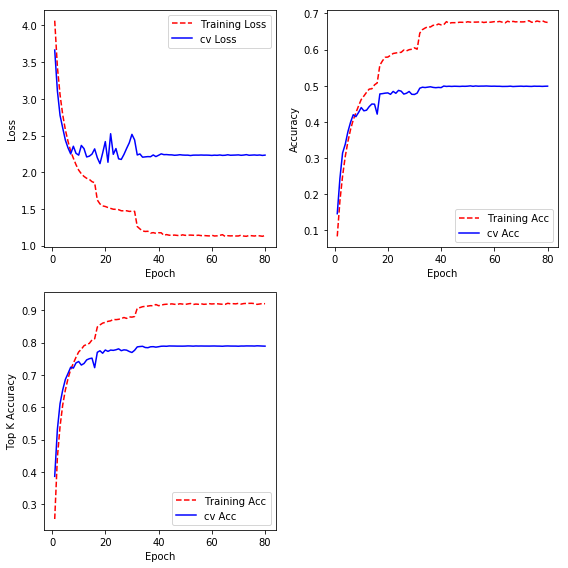

In [91]:
# Get training and cv loss histories
training_loss = history.history['loss']
cv_loss = history.history['val_loss']

training_acc = history.history['accuracy']
cv_acc = history.history['val_accuracy']

training_acc_topk = history.history['top_k_categorical_accuracy']
cv_acc_topk = history.history['val_top_k_categorical_accuracy']
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, cv_loss, 'b-')
plt.legend(['Training Loss', 'cv Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2,2,2)
# Visualize accuracy
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, cv_acc, 'b-')
plt.legend(['Training Acc', 'cv Acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(2,2,3)
# Visualize top_K loss
plt.plot(epoch_count, training_acc_topk, 'r--')
plt.plot(epoch_count, cv_acc_topk, 'b-')
plt.legend(['Training Acc', 'cv Acc'])
plt.xlabel('Epoch')
plt.ylabel('Top K Accuracy')


plt.tight_layout()
plt.show();

In [49]:
# Training CNN model using auto-encoders
# 
# Lets create an auto-encoder model unspervised learning and use the weights learned from the auto-encoder to see what difference does
# it make to accuracy rates;

#Step 1. Encode all layers

batch_size = 128
num_classes = 100
epochs = 50

inputs = Input((32,32,3))
encoder = Conv2D(64, (3, 3), activation='relu')(inputs)
encoder = Conv2D(64, (3, 3), activation='relu')(encoder)
encoder = MaxPooling2D((2, 2))(encoder)
encoder = Dropout(0.25)(encoder)
encoder = Conv2D(128, (3, 3), activation='relu')(encoder)
encoder = Conv2D(128, (3, 3), activation='relu')(encoder)
encoder = MaxPooling2D((2, 2))(encoder)
encoder = Dropout(0.25)(encoder)
encoder = Flatten()(encoder)
encoder = Dense(128, activation='softmax')(encoder)
encoder = Dropout(0.25)(encoder)

final_encoder_layer = Dense(100, activation='softmax')(encoder)

#DECODER

decoder = Reshape((10,10,3))(final_encoder_layer)
decoder = Conv2DTranspose(128,(3, 3), strides=2, activation='relu', padding='same')(decoder)
decoder = Conv2DTranspose(128,(3, 3), strides=2, activation='relu', padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same')(decoder)
decoder = Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same')(decoder)
decoder = BatchNormalization()(decoder)

final_encoder_layer = Conv2D(1, (3, 3), activation='relu', padding='same')(decoder)
auto_encoding_preTrain_model = Model(inputs, final_encoder_layer)
auto_encoding_preTrain_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 10, 10, 128)       1475

# Train models based on Resnet architecture

In [26]:
# Source: https://keras.io/examples/cifar10_resnet/

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [38]:
# Source: https://keras.io/examples/cifar10_resnet/
    
def resnet_v1(input_shape, depth, num_classes=100):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            
                       
            x = tensorflow.keras.layers.add([x, y])
            #x = tensorflow.keras.layers.maximum([x, y])
            x = Activation('relu')(x)
            
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [45]:
# Define a maxres model with 8 to 12 different blocks and test with different number of blocks for model comparison

def maxres12(input_shape, depth, num_classes=100):
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    
    # First set: Input-Conv2D-BN-RELU-LINK1-Conv2D-BN-RELU-Conv2D-BN-RELU-LINK2-ADD(LINK1+LINK2)-RELU
    strides = 1
    
    y = resnet_layer(inputs=x,
                     num_filters=num_filters,
                     strides=strides)
    y = resnet_layer(inputs=y,
                     num_filters=num_filters,
                     activation=None)
                
    #x = Activation('relu')(x)
    x = tensorflow.keras.layers.maximum([x, y])
    #x = Activation('relu')(x)
    
    
    # Second set: Conv2D-BN-RELU-LINK1-Conv2D-BN-RELU-Conv2D-BN-RELU-LINK2-ADD(LINK1+LINK2)-RELU
    
    y = resnet_layer(inputs=x,
                     num_filters=num_filters,
                     strides=strides)
    y = resnet_layer(inputs=y,
                     num_filters=num_filters,
                     activation=None)
                
    #x = Activation('relu')(x)
    x = tensorflow.keras.layers.maximum([x, y])
    #x = Activation('relu')(x)
    
    # Third set: Conv2D-BN-RELU-LINK1-Conv2D-BN-RELU-Conv2D-BN-RELU-LINK2-ADD(LINK1+LINK2)-RELU
    
    y = resnet_layer(inputs=x,
                     num_filters=num_filters,
                     strides=strides)
    y = resnet_layer(inputs=y,
                     num_filters=num_filters,
                     activation=None)
                
    #x = Activation('relu')(x)
    x = tensorflow.keras.layers.maximum([x, y])
    #x = Activation('relu')(x)
    
    #Fourth Set
    y = resnet_layer(inputs=x,
                     num_filters=num_filters,
                     strides=strides)
    y = resnet_layer(inputs=y,
                     num_filters=num_filters,
                     activation=None)
                
    #x = Activation('relu')(x)
    x = tensorflow.keras.layers.maximum([x, y])
    #x = Activation('relu')(x)
    
    # Fifth set: Conv2D-BN-RELU-LINK1-Conv2D-BN-RELU-change dimension-Conv2D-BN-RELU-LINK2-ADD(LINK1+LINK2)-RELU
    # Double number of filters
    num_filters *= 2
    
    #Increase #of strides
    strides = 2
    
    
    y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
    y = resnet_layer(inputs=y,
                     num_filters=num_filters,
                     activation=None)
    
    #change dimensions
    x = resnet_layer(inputs=x,
                     num_filters=num_filters,
                     kernel_size=1,
                     strides=strides,
                     activation=None,
                     batch_normalization=False)
    #x = Activation('relu')(x)
    x = tensorflow.keras.layers.maximum([x, y])
    #x = Activation('relu')(x)
    
    
    
    
    # Sixth set: Conv2D-BN-RELU-LINK1-Conv2D-BN-RELU-change dimension-Conv2D-BN-RELU-LINK2-ADD(LINK1+LINK2)-RELU
    strides = 1
    y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
    y = resnet_layer(inputs=y,
                     num_filters=num_filters,
                     activation=None)
    
    #x = Activation('relu')(x)
    x = tensorflow.keras.layers.maximum([x, y])
    #x = Activation('relu')(x)
    
    # Seventh set: Conv2D-BN-RELU-LINK1-Conv2D-BN-RELU-change dimension-Conv2D-BN-RELU-LINK2-ADD(LINK1+LINK2)-RELU
    strides = 1
    y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
    y = resnet_layer(inputs=y,
                     num_filters=num_filters,
                     activation=None)
    
    #x = Activation('relu')(x)
    x = tensorflow.keras.layers.maximum([x, y])
    #x = Activation('relu')(x)
    
    # Eigth set: Conv2D-BN-RELU-LINK1-Conv2D-BN-RELU-change dimension-Conv2D-BN-RELU-LINK2-ADD(LINK1+LINK2)-RELU
    strides = 1
    y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
    y = resnet_layer(inputs=y,
                     num_filters=num_filters,
                     activation=None)
    
    #x = Activation('relu')(x)
    x = tensorflow.keras.layers.maximum([x, y])
    #x = Activation('relu')(x)
    
    
    # Ninth set: Conv2D-BN-RELU-LINK1-Conv2D-BN-RELU-change dimension-Conv2D-BN-RELU-LINK2-ADD(LINK1+LINK2)-RELU
    # Double number of filters
    num_filters *= 2
    
    #Increase #of strides
    strides = 2
    
    
    y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
    y = resnet_layer(inputs=y,
                     num_filters=num_filters,
                     activation=None)
    
    #change dimensions
    x = resnet_layer(inputs=x,
                     num_filters=num_filters,
                     kernel_size=1,
                     strides=strides,
                     activation=None,
                     batch_normalization=False)
    #x = Activation('relu')(x)
    x = tensorflow.keras.layers.maximum([x, y])
    #x = Activation('relu')(x)
    
    '''   
    
    # Tenth set: Conv2D-BN-RELU-LINK1-Conv2D-BN-RELU-change dimension-Conv2D-BN-RELU-LINK2-ADD(LINK1+LINK2)-RELU
    strides = 1
    y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
    y = resnet_layer(inputs=y,
                     num_filters=num_filters,
                     activation=None)
    
    #x = Activation('relu')(x)
    x = tensorflow.keras.layers.maximum([x, y])
    #x = Activation('relu')(x)
    
    # Eleventh set: Conv2D-BN-RELU-LINK1-Conv2D-BN-RELU-change dimension-Conv2D-BN-RELU-LINK2-ADD(LINK1+LINK2)-RELU
    strides = 1
    y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
    y = resnet_layer(inputs=y,
                     num_filters=num_filters,
                     activation=None)
    
    #x = Activation('relu')(x)
    x = tensorflow.keras.layers.maximum([x, y])
    #x = Activation('relu')(x)
    
    # 12th set: Conv2D-BN-RELU-LINK1-Conv2D-BN-RELU-change dimension-Conv2D-BN-RELU-LINK2-ADD(LINK1+LINK2)-RELU
    strides = 1
    y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
    y = resnet_layer(inputs=y,
                     num_filters=num_filters,
                     activation=None)
    
    #x = Activation('relu')(x)
    x = tensorflow.keras.layers.maximum([x, y])
    #x = Activation('relu')(x)
    
    
    num_filters *= 2
    '''
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,activation='softmax',kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [41]:
# Create Base Resnet-20 model
# Input image dimensions.

input_shape = train_data.shape[1:]

# Create the neural network. Depth is hardcoded to 20.
ResNet_model = resnet_v1(input_shape=input_shape, depth=20)

ResNet_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_for_ResNet(0)),
              metrics=['accuracy','top_k_categorical_accuracy'])

ResNet_model.summary()

Learning rate during this epoch 0.001 0
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 32, 32, 16)   448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_57 (BatchNo (None, 32, 32, 16)   64          conv2d_62[0][0]                  
__________________________________________________________________________________________________
activation_39 (Activation)      (None, 32, 32, 16)   0           batch_normalization_57[0][0]     
____________________________________________________

In [46]:
# Create Maxnet models
# Input image dimensions.

input_shape = train_data.shape[1:]

# Create the neural network
MaxRes_model = maxres12(input_shape=input_shape, depth=12)

MaxRes_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_for_ResNet(0)),
              metrics=['accuracy','top_k_categorical_accuracy'])

MaxRes_model.summary()

Learning rate during this epoch 0.001 0
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_129 (Conv2D)             (None, 32, 32, 16)   448         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_118 (BatchN (None, 32, 32, 16)   64          conv2d_129[0][0]                 
__________________________________________________________________________________________________
activation_80 (Activation)      (None, 32, 32, 16)   0           batch_normalization_118[0][0]    
____________________________________________________

In [47]:

BATCH_SIZE_Resnet = 128



start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_for_ResNet)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]


# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # set range for random shear
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)


# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(train_data)

# Fit the model on the batches generated by datagen.flow().
history_ResNet = ResNet_model.fit_generator(datagen.flow(train_data, y_train, batch_size=128),
                    validation_data=(val_data, y_val),
                    epochs=120, verbose=1, workers=1,
                    callbacks=callbacks, use_multiprocessing=False)



end_time = time.time()
print('Total trianing time (mins):', (end_time-start_time)/60)


score = ResNet_model.evaluate(test_data, y_test, verbose=0)
print('Test loss:',score[0])
print('Test accuracy:',score[1])

Learning rate during this epoch 0.001 0
Epoch 1/120
313/313 [==============================] - 87s 276ms/step - loss: 4.2910 - accuracy: 0.0838 - top_k_categorical_accuracy: 0.2524 - val_loss: 4.0900 - val_accuracy: 0.0992 - val_top_k_categorical_accuracy: 0.2864
Learning rate during this epoch 0.001 1
Epoch 2/120
313/313 [==============================] - 86s 276ms/step - loss: 3.6525 - accuracy: 0.1621 - top_k_categorical_accuracy: 0.4205 - val_loss: 3.9213 - val_accuracy: 0.1464 - val_top_k_categorical_accuracy: 0.3942
Learning rate during this epoch 0.001 2
Epoch 3/120
313/313 [==============================] - 86s 275ms/step - loss: 3.3201 - accuracy: 0.2226 - top_k_categorical_accuracy: 0.5103 - val_loss: 3.4410 - val_accuracy: 0.1939 - val_top_k_categorical_accuracy: 0.4819
Learning rate during this epoch 0.001 3
Epoch 4/120
313/313 [==============================] - 86s 275ms/step - loss: 3.0789 - accuracy: 0.2663 - top_k_categorical_accuracy: 0.5729 - val_loss: 3.2934 - val_ac

Learning rate during this epoch 5e-05 31
Epoch 32/120
313/313 [==============================] - 86s 275ms/step - loss: 1.4101 - accuracy: 0.6494 - top_k_categorical_accuracy: 0.9021 - val_loss: 1.8298 - val_accuracy: 0.5470 - val_top_k_categorical_accuracy: 0.8358
Learning rate during this epoch 5e-05 32
Epoch 33/120
313/313 [==============================] - 86s 275ms/step - loss: 1.3823 - accuracy: 0.6550 - top_k_categorical_accuracy: 0.9027 - val_loss: 1.8130 - val_accuracy: 0.5525 - val_top_k_categorical_accuracy: 0.8382
Learning rate during this epoch 5e-05 33
Epoch 34/120
313/313 [==============================] - 86s 275ms/step - loss: 1.3692 - accuracy: 0.6575 - top_k_categorical_accuracy: 0.9068 - val_loss: 1.8258 - val_accuracy: 0.5523 - val_top_k_categorical_accuracy: 0.8385
Learning rate during this epoch 5e-05 34
Epoch 35/120
313/313 [==============================] - 86s 276ms/step - loss: 1.3590 - accuracy: 0.6607 - top_k_categorical_accuracy: 0.9075 - val_loss: 1.8415 

Learning rate during this epoch 1e-06 62
Epoch 63/120
313/313 [==============================] - 87s 278ms/step - loss: 1.3172 - accuracy: 0.6744 - top_k_categorical_accuracy: 0.9117 - val_loss: 1.8074 - val_accuracy: 0.5565 - val_top_k_categorical_accuracy: 0.8408
Learning rate during this epoch 1e-06 63
Epoch 64/120
313/313 [==============================] - 86s 276ms/step - loss: 1.3131 - accuracy: 0.6740 - top_k_categorical_accuracy: 0.9123 - val_loss: 1.8069 - val_accuracy: 0.5571 - val_top_k_categorical_accuracy: 0.8406
Learning rate during this epoch 1e-06 64
Epoch 65/120
313/313 [==============================] - 87s 277ms/step - loss: 1.3112 - accuracy: 0.6743 - top_k_categorical_accuracy: 0.9138 - val_loss: 1.8094 - val_accuracy: 0.5572 - val_top_k_categorical_accuracy: 0.8406
Learning rate during this epoch 1e-06 65
Epoch 66/120
313/313 [==============================] - 86s 275ms/step - loss: 1.3118 - accuracy: 0.6739 - top_k_categorical_accuracy: 0.9128 - val_loss: 1.8071 

Learning rate during this epoch 1e-06 93
Epoch 94/120
313/313 [==============================] - 86s 276ms/step - loss: 1.3072 - accuracy: 0.6768 - top_k_categorical_accuracy: 0.9136 - val_loss: 1.8049 - val_accuracy: 0.5583 - val_top_k_categorical_accuracy: 0.8401
Learning rate during this epoch 1e-06 94
Epoch 95/120
313/313 [==============================] - 87s 277ms/step - loss: 1.3132 - accuracy: 0.6730 - top_k_categorical_accuracy: 0.9139 - val_loss: 1.8081 - val_accuracy: 0.5571 - val_top_k_categorical_accuracy: 0.8405
Learning rate during this epoch 1e-06 95
Epoch 96/120
313/313 [==============================] - 87s 278ms/step - loss: 1.3054 - accuracy: 0.6745 - top_k_categorical_accuracy: 0.9145 - val_loss: 1.8071 - val_accuracy: 0.5579 - val_top_k_categorical_accuracy: 0.8408
Learning rate during this epoch 1e-06 96
Epoch 97/120
313/313 [==============================] - 86s 276ms/step - loss: 1.3121 - accuracy: 0.6732 - top_k_categorical_accuracy: 0.9139 - val_loss: 1.8096 

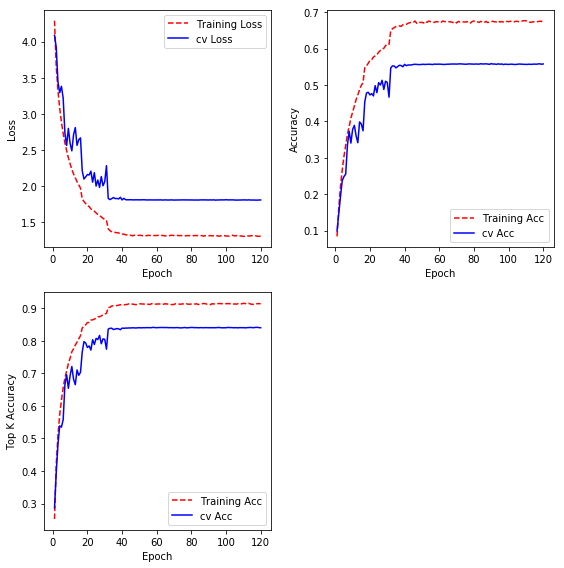

In [48]:
# Get training and cv loss histories for ResNet-20

training_loss = history_ResNet.history['loss']
cv_loss = history_ResNet.history['val_loss']

training_acc = history_ResNet.history['accuracy']
cv_acc = history_ResNet.history['val_accuracy']

training_acc_topk = history_ResNet.history['top_k_categorical_accuracy']
cv_acc_topk = history_ResNet.history['val_top_k_categorical_accuracy']
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, cv_loss, 'b-')
plt.legend(['Training Loss', 'cv Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2,2,2)
# Visualize accuracy
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, cv_acc, 'b-')
plt.legend(['Training Acc', 'cv Acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(2,2,3)
# Visualize top_K loss
plt.plot(epoch_count, training_acc_topk, 'r--')
plt.plot(epoch_count, cv_acc_topk, 'b-')
plt.legend(['Training Acc', 'cv Acc'])
plt.xlabel('Epoch')
plt.ylabel('Top K Accuracy')


plt.tight_layout()
plt.show();

In [49]:

# Train maxres

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_for_ResNet)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]


# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # set range for random shear
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)


# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(train_data)

# Fit the model on the batches generated by datagen.flow().
history_MaxRes = MaxRes_model.fit_generator(datagen.flow(train_data, y_train, batch_size=128),
                    validation_data=(val_data, y_val),
                    epochs=120, verbose=1, workers=1,
                    callbacks=callbacks, use_multiprocessing=False)



end_time = time.time()
print('Total trianing time (mins):', (end_time-start_time)/60)


score = MaxRes_model.evaluate(test_data, y_test, verbose=0)
print('Test loss:',score[0])
print('Test accuracy:',score[1])

Learning rate during this epoch 0.001 0
Epoch 1/120
313/313 [==============================] - 89s 285ms/step - loss: 4.3056 - accuracy: 0.0791 - top_k_categorical_accuracy: 0.2464 - val_loss: 4.0256 - val_accuracy: 0.0968 - val_top_k_categorical_accuracy: 0.3018
Learning rate during this epoch 0.001 1
Epoch 2/120
313/313 [==============================] - 88s 280ms/step - loss: 3.6969 - accuracy: 0.1514 - top_k_categorical_accuracy: 0.3997 - val_loss: 3.6531 - val_accuracy: 0.1532 - val_top_k_categorical_accuracy: 0.4160
Learning rate during this epoch 0.001 2
Epoch 3/120
313/313 [==============================] - 88s 283ms/step - loss: 3.3785 - accuracy: 0.2046 - top_k_categorical_accuracy: 0.4889 - val_loss: 3.4505 - val_accuracy: 0.1988 - val_top_k_categorical_accuracy: 0.4688
Learning rate during this epoch 0.001 3
Epoch 4/120
313/313 [==============================] - 88s 281ms/step - loss: 3.1387 - accuracy: 0.2471 - top_k_categorical_accuracy: 0.5531 - val_loss: 3.6850 - val_ac

Learning rate during this epoch 5e-05 31
Epoch 32/120
313/313 [==============================] - 89s 284ms/step - loss: 1.6146 - accuracy: 0.5794 - top_k_categorical_accuracy: 0.8664 - val_loss: 1.9451 - val_accuracy: 0.5121 - val_top_k_categorical_accuracy: 0.8112
Learning rate during this epoch 5e-05 32
Epoch 33/120
313/313 [==============================] - 88s 282ms/step - loss: 1.5911 - accuracy: 0.5879 - top_k_categorical_accuracy: 0.8705 - val_loss: 1.9283 - val_accuracy: 0.5158 - val_top_k_categorical_accuracy: 0.8144
Learning rate during this epoch 5e-05 33
Epoch 34/120
313/313 [==============================] - 88s 281ms/step - loss: 1.5866 - accuracy: 0.5882 - top_k_categorical_accuracy: 0.8693 - val_loss: 1.9067 - val_accuracy: 0.5160 - val_top_k_categorical_accuracy: 0.8183
Learning rate during this epoch 5e-05 34
Epoch 35/120
313/313 [==============================] - 88s 281ms/step - loss: 1.5764 - accuracy: 0.5902 - top_k_categorical_accuracy: 0.8711 - val_loss: 1.9477 

Learning rate during this epoch 1e-06 62
Epoch 63/120
313/313 [==============================] - 88s 282ms/step - loss: 1.5428 - accuracy: 0.5990 - top_k_categorical_accuracy: 0.8751 - val_loss: 1.9104 - val_accuracy: 0.5193 - val_top_k_categorical_accuracy: 0.8182
Learning rate during this epoch 1e-06 63
Epoch 64/120
313/313 [==============================] - 88s 280ms/step - loss: 1.5462 - accuracy: 0.5992 - top_k_categorical_accuracy: 0.8755 - val_loss: 1.9134 - val_accuracy: 0.5187 - val_top_k_categorical_accuracy: 0.8179
Learning rate during this epoch 1e-06 64
Epoch 65/120
313/313 [==============================] - 88s 280ms/step - loss: 1.5484 - accuracy: 0.5982 - top_k_categorical_accuracy: 0.8750 - val_loss: 1.9113 - val_accuracy: 0.5194 - val_top_k_categorical_accuracy: 0.8176
Learning rate during this epoch 1e-06 65
Epoch 66/120
313/313 [==============================] - 87s 279ms/step - loss: 1.5425 - accuracy: 0.5997 - top_k_categorical_accuracy: 0.8769 - val_loss: 1.9131 

Learning rate during this epoch 1e-06 93
Epoch 94/120
313/313 [==============================] - 88s 280ms/step - loss: 1.5385 - accuracy: 0.5997 - top_k_categorical_accuracy: 0.8760 - val_loss: 1.9130 - val_accuracy: 0.5192 - val_top_k_categorical_accuracy: 0.8185
Learning rate during this epoch 1e-06 94
Epoch 95/120
313/313 [==============================] - 87s 278ms/step - loss: 1.5397 - accuracy: 0.6021 - top_k_categorical_accuracy: 0.8768 - val_loss: 1.9142 - val_accuracy: 0.5187 - val_top_k_categorical_accuracy: 0.8182
Learning rate during this epoch 1e-06 95
Epoch 96/120
313/313 [==============================] - 87s 279ms/step - loss: 1.5367 - accuracy: 0.6018 - top_k_categorical_accuracy: 0.8765 - val_loss: 1.9120 - val_accuracy: 0.5195 - val_top_k_categorical_accuracy: 0.8188
Learning rate during this epoch 1e-06 96
Epoch 97/120
313/313 [==============================] - 87s 278ms/step - loss: 1.5426 - accuracy: 0.6013 - top_k_categorical_accuracy: 0.8767 - val_loss: 1.9146 

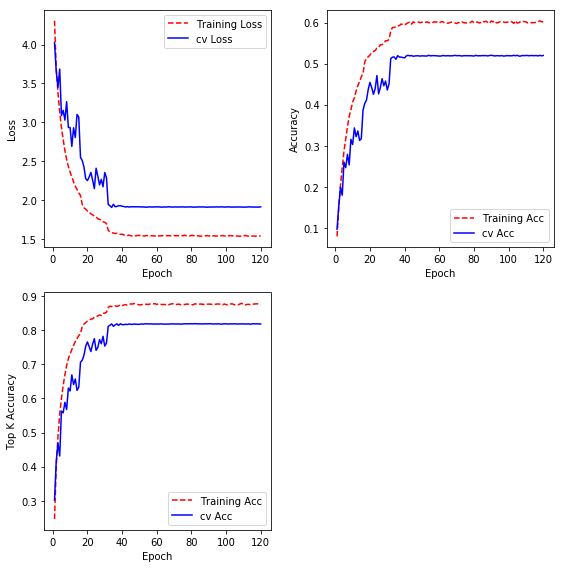

In [50]:
# Get training and cv loss histories for ResNet-20

training_loss = history_MaxRes.history['loss']
cv_loss = history_MaxRes.history['val_loss']

training_acc = history_MaxRes.history['accuracy']
cv_acc = history_MaxRes.history['val_accuracy']

training_acc_topk = history_MaxRes.history['top_k_categorical_accuracy']
cv_acc_topk = history_MaxRes.history['val_top_k_categorical_accuracy']
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, cv_loss, 'b-')
plt.legend(['Training Loss', 'cv Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2,2,2)
# Visualize accuracy
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, cv_acc, 'b-')
plt.legend(['Training Acc', 'cv Acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(2,2,3)
# Visualize top_K loss
plt.plot(epoch_count, training_acc_topk, 'r--')
plt.plot(epoch_count, cv_acc_topk, 'b-')
plt.legend(['Training Acc', 'cv Acc'])
plt.xlabel('Epoch')
plt.ylabel('Top K Accuracy')


plt.tight_layout()
plt.show();

In [51]:
MaxRes_model.save('/home/ubuntu/CSC522/Maxres.h5')
ResNet_model.save('/home/ubuntu/CSC522/Resnet.h5')

In [2]:
MaxRes_model = load_model('/home/ubuntu/CSC522/Maxres.h5')
ResNet_model = load_model('/home/ubuntu/CSC522/Resnet.h5')

In [30]:
start_time = time.time()
pred_time_maxres = MaxRes_model.evaluate(test_data, y_test, verbose=0)

end_time = time.time()
print('Total prediction time for MaxRes model:', end_time-start_time)

start_time = time.time()
pred_time_resnet = ResNet_model.evaluate(test_data, y_test, verbose=0)

end_time = time.time()
print('Total prediction time for ResNet model:', end_time-start_time)

Total prediction time for MaxRes model: 3.7001302242279053
Total prediction time for ResNet model: 3.570780038833618


In [31]:
im1 = Image.open('/home/ubuntu/CSC522/Test_Images/butterfly_16x9_0.jpg','r')
im2 = Image.open('/home/ubuntu/CSC522/Test_Images/bicycle_1.jpg','r') 
im3 = Image.open('/home/ubuntu/CSC522/Test_Images/butterfly_2.jpg','r') 
im4 = Image.open('/home/ubuntu/CSC522/Test_Images/butterfly_3.jpg','r') 
im5 = Image.open('/home/ubuntu/CSC522/Test_Images/elephant_1.jpg','r') 
im6 = Image.open('/home/ubuntu/CSC522/Test_Images/mountain_1.jpg','r') 
im7 = Image.open('/home/ubuntu/CSC522/Test_Images/tractor_1.jpg','r') 
im8 = Image.open('/home/ubuntu/CSC522/Test_Images/Lion.JPG','r') 

new_im1 = im1.resize((32,32),Image.ANTIALIAS)
new_im2 = im2.resize((32,32),Image.ANTIALIAS)
new_im3 = im3.resize((32,32),Image.ANTIALIAS)
new_im4 = im4.resize((32,32),Image.ANTIALIAS)
new_im5 = im5.resize((32,32),Image.ANTIALIAS)
new_im6 = im6.resize((32,32),Image.ANTIALIAS)
new_im7 = im7.resize((32,32),Image.ANTIALIAS)
new_im8 = im8.resize((32,32),Image.ANTIALIAS)

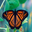

In [32]:
from IPython.display import display
display(new_im1)

In [33]:
test_img_array1 = np.array(new_im1)
test_img_array1 = test_img_array1.reshape(1,32,32,3)

test_img_array2 = np.array(new_im2)
test_img_array2 = test_img_array2.reshape(1,32,32,3)

test_img_array3 = np.array(new_im3)
test_img_array3 = test_img_array3.reshape(1,32,32,3)

test_img_array4 = np.array(new_im4)
test_img_array4 = test_img_array4.reshape(1,32,32,3)

test_img_array5 = np.array(new_im5)
test_img_array5 = test_img_array5.reshape(1,32,32,3)

test_img_array6 = np.array(new_im6)
test_img_array6 = test_img_array6.reshape(1,32,32,3)

test_img_array7 = np.array(new_im7)
test_img_array7 = test_img_array7.reshape(1,32,32,3)

test_img_array8 = np.array(new_im8)
test_img_array8 = test_img_array8.reshape(1,32,32,3)




In [67]:
MaxRes_results = []
MaxRes_preds = []
Resnet_results = []
ResNet_preds = []

In [68]:
MaxRes_results = []
start_time = time.time()
result = MaxRes_model.predict(test_img_array1.astype('float32')/127.5 - 1.)
MaxRes_preds.append(np.where(result == np.amax(result)))
end_time = time.time()
MaxRes_results.append(end_time - start_time)

start_time = time.time()
result = MaxRes_model.predict(test_img_array2.astype('float32')/127.5 - 1.)
MaxRes_preds.append(np.where(result == np.amax(result)))
end_time = time.time()
MaxRes_results.append(end_time - start_time)

start_time = time.time()
result = MaxRes_model.predict(test_img_array3.astype('float32')/127.5 - 1.)
MaxRes_preds.append(np.where(result == np.amax(result)))
end_time = time.time()
MaxRes_results.append(end_time - start_time)

start_time = time.time()
result = MaxRes_model.predict(test_img_array4.astype('float32')/127.5 - 1.)
MaxRes_preds.append(np.where(result == np.amax(result)))
end_time = time.time()
MaxRes_results.append(end_time - start_time)

start_time = time.time()
result = MaxRes_model.predict(test_img_array5.astype('float32')/127.5 - 1.)
MaxRes_preds.append(np.where(result == np.amax(result)))
end_time = time.time()
MaxRes_results.append(end_time - start_time)

start_time = time.time()
result = MaxRes_model.predict(test_img_array6.astype('float32')/127.5 - 1.)
MaxRes_preds.append(np.where(result == np.amax(result)))
end_time = time.time()
MaxRes_results.append(end_time - start_time)

start_time = time.time()
result = MaxRes_model.predict(test_img_array7.astype('float32')/127.5 - 1.)
MaxRes_preds.append(np.where(result == np.amax(result)))
end_time = time.time()
MaxRes_results.append(end_time - start_time)

start_time = time.time()
result = MaxRes_model.predict(test_img_array8.astype('float32')/127.5 - 1.)
MaxRes_preds.append(np.where(result == np.amax(result)))
end_time = time.time()
MaxRes_results.append(end_time - start_time)

In [69]:
start_time = time.time()
result = ResNet_model.predict(test_img_array1.astype('float32')/127.5 - 1.)
ResNet_preds.append(np.where(result == np.amax(result)))
end_time = time.time()
Resnet_results.append(end_time - start_time)

start_time = time.time()
result = ResNet_model.predict(test_img_array2.astype('float32')/127.5 - 1.)
ResNet_preds.append(np.where(result == np.amax(result)))
end_time = time.time()
Resnet_results.append(end_time - start_time)

start_time = time.time()
result = ResNet_model.predict(test_img_array3.astype('float32')/127.5 - 1.)
ResNet_preds.append(np.where(result == np.amax(result)))
end_time = time.time()
Resnet_results.append(end_time - start_time)

start_time = time.time()
result = ResNet_model.predict(test_img_array4.astype('float32')/127.5 - 1.)
ResNet_preds.append(np.where(result == np.amax(result)))
end_time = time.time()
Resnet_results.append(end_time - start_time)

start_time = time.time()
result = ResNet_model.predict(test_img_array5.astype('float32')/127.5 - 1.)
ResNet_preds.append(np.where(result == np.amax(result)))
end_time = time.time()
Resnet_results.append(end_time - start_time)

start_time = time.time()
result = ResNet_model.predict(test_img_array6.astype('float32')/127.5 - 1.)
ResNet_preds.append(np.where(result == np.amax(result)))
end_time = time.time()
Resnet_results.append(end_time - start_time)

start_time = time.time()
result = ResNet_model.predict(test_img_array7.astype('float32')/127.5 - 1.)
ResNet_preds.append(np.where(result == np.amax(result)))
end_time = time.time()
Resnet_results.append(end_time - start_time)

start_time = time.time()
result = ResNet_model.predict(test_img_array8.astype('float32')/127.5 - 1.)
ResNet_preds.append(np.where(result == np.amax(result)))
end_time = time.time()
Resnet_results.append(end_time - start_time)

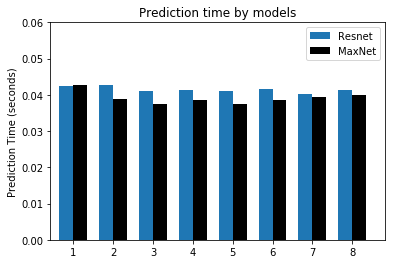

In [53]:
import matplotlib.pyplot as plt
N = 5
men_means = (20, 35, 30, 35, 27)
women_means = (25, 32, 34, 20, 25)

ind = np.arange(len(Resnet_results)) 
width = 0.35       
plt.bar(ind, Resnet_results, width, label='Resnet',color='C0')
plt.bar(ind + width, MaxRes_results, width,label='MaxNet',color='k')

plt.ylabel('Prediction Time (seconds)')
plt.title('Prediction time by models')

plt.xticks(ind + width / 2, ('1', '2', '3', '4', '5', '6', '7', '8'))
plt.legend(loc='best')
axes = plt.gca()
axes.set_xlim([-0.4,8])
axes.set_ylim([0,0.06])

plt.show()

In [70]:
Test_image_true_lables = [14,8,14,14,31,49,89,43]
MaxRes_preds

[(array([0]), array([14])),
 (array([0]), array([48])),
 (array([0]), array([14])),
 (array([0]), array([14])),
 (array([0]), array([31])),
 (array([0]), array([49])),
 (array([0]), array([13])),
 (array([0]), array([88]))]

In [71]:
ResNet_preds

[(array([0]), array([14])),
 (array([0]), array([48])),
 (array([0]), array([14])),
 (array([0]), array([14])),
 (array([0]), array([31])),
 (array([0]), array([49])),
 (array([0]), array([13])),
 (array([0]), array([43]))]